# 510 Students

1. Use a completely different technique to classify cluster members.  How do your results compare to previous attempts?

In [642]:
import numpy as np
from scipy.special import expit
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd

In [643]:
gaia_df = pd.read_csv('C:/Users/rabin/sci-comp-ii-fall24/Working/final_NGC-6397-project/data/gaia-NGC6397-neighborhood.csv')
Cluster_df = pd.read_fwf('C:/Users/rabin/sci-comp-ii-fall24/Working/final_NGC-6397-project/data/NGC6397-1.dat')

In [644]:
# Assignning names manually because they don't have it.
Cluster_df.columns = ['source_id', 'ra', 'dec', 'phot_g_mean_mag']

# Verify the column names
print(Cluster_df.head())

             source_id         ra       dec  phot_g_mean_mag
0  5921539825546549120  264.25211 -54.06070           19.086
1  5921542265088057472  264.20510 -53.94871           18.252
2  5921539585011442304  264.33958 -54.03101           19.001
3  5921530887707179136  264.28545 -54.20321           17.558
4  5921543192800960640  264.19193 -54.01173           19.580


In [645]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Regularization term
def cost(theta, X, y, reg):
    m = len(y)
    h = sigmoid(X.dot(theta))

    epsilon = 1e-10
    h = np.clip(h, epsilon, 1 - epsilon)
    
    # Calculate cost with regularization (skip regularizing theta[0] for the intercept)
    J = -1/m * (y.T.dot(np.log(h)) + (1 - y).T.dot(np.log(1 - h)) + reg/(2*m) * np.sum(np.square(theta)))
    
    return J

# Cost gradient
def cost_gradient(theta, X, y, reg):
    m = len(y)
    h = sigmoid(X.dot(theta))
    gradient = 1/m * X.T.dot(h - y) 
    gradient[1:] += (reg/m) * theta[1:]
    return gradient


# One-vs-All approach for multiple cluster classification
def one_v_all(X, y, n_classes, reg=0.1):
    n_samples, n_features = X.shape

    thetas = np.zeros((n_classes, n_features))

    for cls in range(n_classes):
        y_binary = (y == cls).astype(int)
        theta0 = np.zeros(n_features)
        res = minimize(cost, theta0, args=(X, y_binary, reg), jac=cost_gradient, options={'maxiter': 50})
        thetas[cls] = res.x
    return thetas

# Predict function for one-vs-all classifiers
def predict_one_v_all(thetas, X):
    Ps = expit(X.dot(thetas.T))
    return np.argmax(Ps, axis=1)

In [646]:
Cluster_sel = gaia_df['source_id'].isin(Cluster_df.source_id)
print(np.count_nonzero(Cluster_sel))

21772


In [647]:
params = ['pmra', 'pmdec'] #I found this feature good in my previous exploration.
X = np.array(gaia_df[params])

In [648]:
np.count_nonzero(np.any(np.isnan(X), axis=1))

36346

In [649]:
nans = np.any(np.isnan(X), axis=1)
X = X[~nans]

n_classes = 2
y = Cluster_sel.astype(int)[~nans]

In [650]:
from sklearn.preprocessing import StandardScaler

In [651]:
transformer = StandardScaler()

X = transformer.fit_transform(X)

In [652]:
# Split data into training and testing (for example, 90% for training, 10% for testing)
training = np.random.choice([True, False], size=len(X), p=[0.9, 0.1])
validating = ~training
X_train = X[training]
y_train = y[training]
X_test = X[validating]
y_test = y[validating]

In [653]:
# Add bias term (intercept) to the features
X_train = np.column_stack([np.ones((X_train.shape[0], 1)), X_train])
X_test = np.column_stack([np.ones((X_test.shape[0], 1)), X_test])

In [654]:
X_train_subset = X_train[:10000]  # Train on a smaller subset of the data
y_train_subset = y_train[:10000]
X_test_subset = X_test[:10000]  
y_test_subset = y_test[:10000]

In [655]:
# Train a logistic regression model
theta = one_v_all(X_train_subset, y_train_subset, 2)  

In [656]:
pred = predict_one_v_all(theta, X_test_subset)

In [657]:
# Evaluate the model
training_acc = np.mean(pred == y_train_subset) * 100
validation_acc = np.mean(pred == y_test_subset) * 100
print(f'Training accuracy: {training_acc:.2f}%')
print(f'Validation accuracy: {validation_acc:.2f}%')

Training accuracy: 99.85%
Validation accuracy: 96.83%


2. Do you think your models have learned anything useful for identifying members of other clusters?  Why or why not?

I dont think my model learned anything for identifying members of other clusters as it was hard to read all the data that was inside the gaia data frame.

<function matplotlib.pyplot.show(close=None, block=None)>

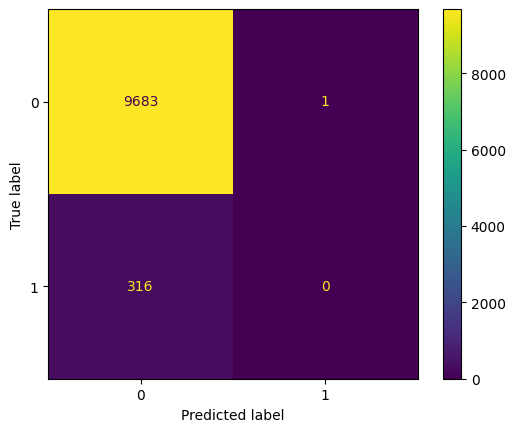

In [658]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

M = confusion_matrix(y_test_subset, pred)

Visualization = ConfusionMatrixDisplay(confusion_matrix=M)
Visualization.plot()
plt.show

3. Can you think of ways we could use the isochrone explicitly to improve our model?

In [659]:
iso_data = pd.read_csv('C:/Users/rabin/sci-comp-ii-fall24/Working/final_NGC-6397-project/data/NGC6397_iso.csv')
iso_data

,Unnamed: 0,bp_rp,Gaia_G_EDR3,phase
0,0,2.239831,24.494631,0.0
1,1,2.217666,24.409392,0.0
2,2,2.194527,24.315058,0.0
3,3,2.172080,24.221950,0.0
4,4,2.150091,24.129340,0.0
...,...,...,...,...
1447,1447,-0.087272,22.475614,6.0
1448,1448,-0.080667,22.519457,6.0
1449,1449,-0.074041,22.562334,6.0
1450,1450,-0.067388,22.604324,6.0


In [660]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Regularization term
def cost(theta, X, y, reg):
    m = len(y)
    h = sigmoid(X.dot(theta)) 

    epsilon = 1e-10
    h = np.clip(h, epsilon, 1 - epsilon)
    
    # Calculate cost with regularization 
    J = -1/m * (y.T.dot(np.log(h)) + (1 - y).T.dot(np.log(1 - h)) + reg/(2*m) * np.sum(np.square(theta)))
    
    return J

# Cost gradient
def cost_gradient(theta, X, y, reg):
    m = len(y)
    h = sigmoid(X.dot(theta))
    gradient = 1/m * X.T.dot(h - y) 
    gradient[1:] += (reg/m) * theta[1:]
    return gradient

# One-vs-All approach for multiple cluster classification
def one_v_all(X, y, n_classes, reg=0.1):
    n_samples, n_features = X.shape

    thetas = np.zeros((n_classes, n_features))

    for cls in range(n_classes):
        y_binary = (y == cls).astype(int)
        theta0 = np.zeros(n_features)
        res = minimize(cost, theta0, args=(X, y_binary, reg), jac=cost_gradient, options={'maxiter': 50})
        thetas[cls] = res.x
    return thetas

# Predict function for one-vs-all classifiers
def predict_one_v_all(thetas, X):
    Ps = expit(X.dot(thetas.T))
    return np.argmax(Ps, axis=1)

In [661]:
params = ['bp_rp', 'Gaia_G_EDR3']
X = np.array(iso_data[params])
X.shape

(1452, 2)

In [662]:
np.count_nonzero(np.any(np.isnan(X), axis=1))

0

In [663]:
nans = np.any(np.isnan(X), axis=1)
X = X[~nans]

n_classes = 2
y = iso_data['phase'].astype(int)[~nans]

In [664]:
from sklearn.preprocessing import StandardScaler

In [665]:
transformer = StandardScaler()

X = transformer.fit_transform(X)

In [666]:
# Split data into training and testing
training = np.random.choice([True, False], size=len(X), p=[0.9, 0.1])
validating = ~training
X_train_iso = X[training]
y_train_iso = y[training]
X_test_iso = X[validating]
y_test_iso = y[validating]

In [667]:
# Add bias term (intercept) to the features
X_train_iso = np.column_stack([np.ones((X_train_iso.shape[0], 1)), X_train_iso])
X_test_iso = np.column_stack([np.ones((X_test_iso.shape[0], 1)), X_test_iso])

In [668]:
X_train_subset_iso = X_train_iso[:100]  # Train on a smaller subset of the data
y_train_subset_iso = y_train_iso[:100]
X_test_subset_iso = X_test_iso[:100]  
y_test_subset_iso = y_test_iso[:100]

In [669]:
# Train a logistic regression model
theta_iso = one_v_all(X_train_subset_iso, y_train_subset_iso, 2)

In [670]:
# Train a logistic regression model
theta_iso = one_v_all(X_train_subset_iso, y_train_subset_iso, 2)

In [671]:
pred_iso = predict_one_v_all(theta_iso, X_test_subset_iso)


In [672]:
# Evaluate the model
training_acc = np.mean(pred_iso == y_train_subset_iso) * 100
validation_acc = np.mean(pred_iso == y_test_subset_iso) * 100
print(f'Training accuracy: {training_acc:.2f}%')
print(f'Validation accuracy: {validation_acc:.2f}%')

Training accuracy: 100.00%
Validation accuracy: 20.00%


<function matplotlib.pyplot.show(close=None, block=None)>

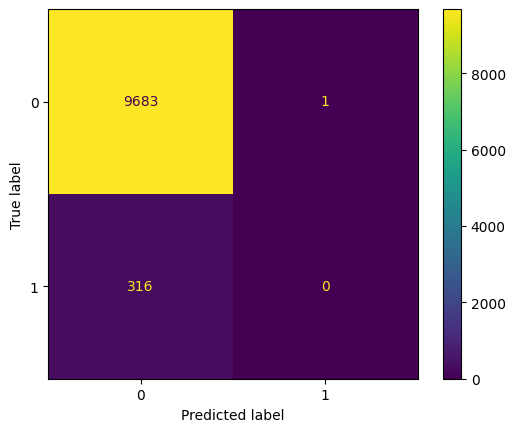

In [673]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

M = confusion_matrix(y_test_subset, pred)

Visualization = ConfusionMatrixDisplay(confusion_matrix=M)
Visualization.plot()
plt.show

I think the problem is not choosing an appropriate model that has many constraints while dealing with a large data file. Validity accuracy is so low, but training accuracy is 100%, implying the model is not reading from generalized data but instead taking knowledge from limited trained data.